<a href="https://colab.research.google.com/github/yuicao4234/DSC-x-CBRE-Datathon-2024/blob/main/vgg16_DSC_DATATHON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import models
from torch.optim.lr_scheduler import StepLR


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import os
from pathlib import Path
data_path = Path("/content/drive/My Drive/Datathon")
img_path = data_path / 'DSC Datathon IMG'

In [43]:
def walk_through_dir(dir_path):
  """Walks through dir_path, returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [44]:
walk_through_dir(img_path)

There are 5 directories and 0 images in '/content/drive/My Drive/Datathon/DSC Datathon IMG'.
There are 0 directories and 16 images in '/content/drive/My Drive/Datathon/DSC Datathon IMG/3'.
There are 0 directories and 67 images in '/content/drive/My Drive/Datathon/DSC Datathon IMG/2'.
There are 0 directories and 68 images in '/content/drive/My Drive/Datathon/DSC Datathon IMG/1'.
There are 0 directories and 17 images in '/content/drive/My Drive/Datathon/DSC Datathon IMG/4'.
There are 0 directories and 48 images in '/content/drive/My Drive/Datathon/DSC Datathon IMG/5'.


/content/drive/My Drive/Datathon/DSC Datathon IMG/5/856328172_5.png
Random image path: /content/drive/My Drive/Datathon/DSC Datathon IMG/5/856328172_5.png
Image Class: 5
Image height: 603
Image width: 297


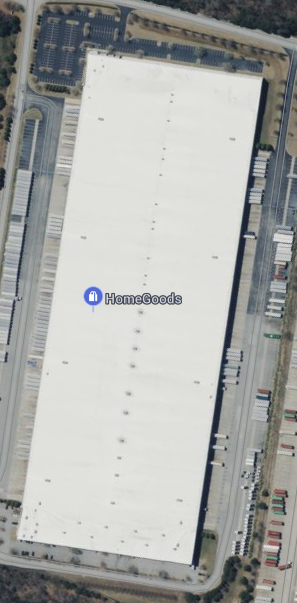

In [45]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
img_path_list = list(img_path.glob("*/*.png"))


# 2. Pick a random image path
random_image_path = random.choice(img_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem


# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [46]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [47]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.to(device)
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
  return train_loss, train_acc

In [48]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)

      test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

    test_loss /= len(data_loader)

    test_acc /= len(data_loader)

  print(f"Test loss: {test_loss:.4f}, test acc: {test_acc:.2f}%")
  return test_loss, test_acc

In [49]:
model = models.vgg16(pretrained = True)
num_classes = 5
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


"\nunfreeze_layers = ['features.24', 'features.26', 'features.28', 'features.29', 'features.30', 'features.31']\n# Unfreeze the selected layers\nfor name, child in model.named_modules():\n    if any (layer in name for layer in unfreeze_layers):\n        for param in child.parameters():\n            param.requires_grad = True\n    else:\n        for param in child.parameters():\n            param.requires_grad = False\n\n# Now, when setting up the optimizer, you can pass the parameters that require grad\noptimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)\n"

In [52]:
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets
import torchvision.transforms as transforms

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomResizedCrop(size=(128, 128), antialias=True),
    transforms.RandomRotation((-0.25,0.25)),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    #transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

# Load dataset without any transforms
dataset = datasets.ImageFolder(root=img_path)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(45))

# Apply transformations to the subsets
train_dataset = Subset(dataset, train_dataset.indices)
test_dataset = Subset(dataset, test_dataset.indices)

# Define a function to apply transformations
def apply_transforms(dataset, transform):
    transformed_data = [(transform(image), label) for image, label in dataset]
    return transformed_data

# Apply transformations
train_dataset = apply_transforms(train_dataset, train_transform)
test_dataset = apply_transforms(test_dataset, test_transform)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [53]:
print(img_path)

/content/drive/My Drive/Datathon/DSC Datathon IMG


In [54]:
len(train_dataloader), len(test_dataloader)

(6, 2)

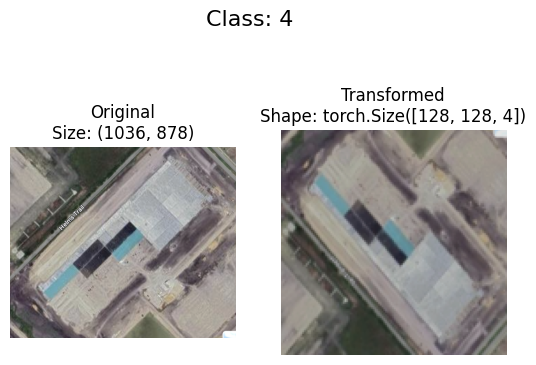

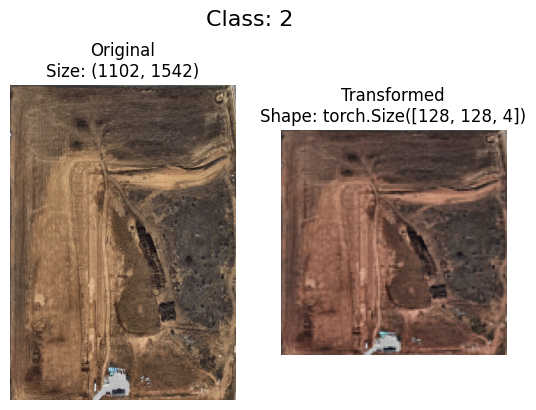

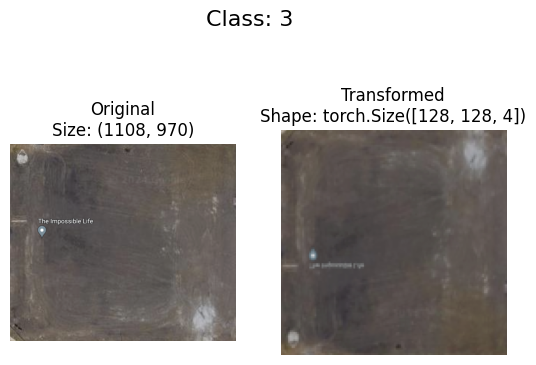

In [55]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):

  #Selects random images from path of images and loads/transforms them and plots original vs transformed images
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = img_path_list, transform = train_transform, n=3, seed=42)

In [56]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, scheduler, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_losses, train_accs = [], []
        test_losses, test_accs = [], []

        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accs.append((y_pred.argmax(1) == y).type(torch.float).sum().item() / len(y))

        results["train_loss"].append(np.mean(train_losses))
        results["train_acc"].append(np.mean(train_accs))

        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                test_losses.append(loss.item())
                test_accs.append((y_pred.argmax(1) == y).type(torch.float).sum().item() / len(y))

        results["test_loss"].append(np.mean(test_losses))
        results["test_acc"].append(np.mean(test_accs))

        print(f"Epoch: {epoch + 1} | Train loss: {np.mean(train_losses):.4f} | Train acc: {np.mean(train_accs) * 100:.2f}% | Test loss: {np.mean(test_losses):.4f} | Test acc: {np.mean(test_accs) * 100:.2f}%")

        scheduler.step()

    return results

def plot_results(results):
    epochs = range(1, len(results["train_acc"]) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["train_acc"], 'bo-', label='Training Accuracy')
    plt.plot(epochs, results["test_acc"], 'ro-', label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, results["train_loss"], 'b^-', label='Training Loss')
    plt.plot(epochs, results["test_loss"], 'r^-', label='Testing Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.6079 | Train acc: 29.51% | Test loss: 1.5283 | Test acc: 31.77%
Epoch: 2 | Train loss: 1.3421 | Train acc: 46.01% | Test loss: 1.4056 | Test acc: 42.19%
Epoch: 3 | Train loss: 1.1730 | Train acc: 54.86% | Test loss: 1.3295 | Test acc: 42.19%
Epoch: 4 | Train loss: 1.0375 | Train acc: 63.72% | Test loss: 1.3279 | Test acc: 45.31%
Epoch: 5 | Train loss: 0.9186 | Train acc: 68.06% | Test loss: 1.2797 | Test acc: 48.44%
Epoch: 6 | Train loss: 0.8531 | Train acc: 71.01% | Test loss: 1.2270 | Test acc: 48.44%
Epoch: 7 | Train loss: 0.8065 | Train acc: 70.31% | Test loss: 1.1479 | Test acc: 46.88%
Epoch: 8 | Train loss: 0.6907 | Train acc: 77.43% | Test loss: 1.0565 | Test acc: 52.60%
Epoch: 9 | Train loss: 0.7374 | Train acc: 73.26% | Test loss: 1.0660 | Test acc: 48.44%
Epoch: 10 | Train loss: 0.6752 | Train acc: 76.74% | Test loss: 1.1556 | Test acc: 48.44%
Epoch: 11 | Train loss: 0.5940 | Train acc: 79.69% | Test loss: 1.0699 | Test acc: 54.17%
Epoch: 12 | Train l

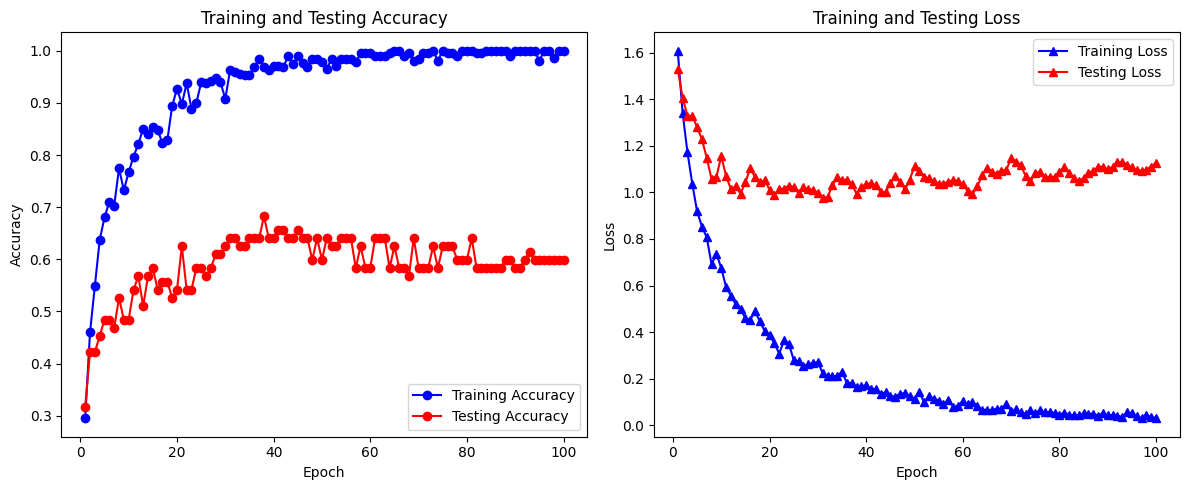

In [57]:
NUM_EPOCHS = 100

from timeit import default_timer as timer

# Start timer
start_time= timer()

# Train model 0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End timer and print time
end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_results(model_results)